## Package Installation

In [1]:
# install ase and amp
!pip3 install amp-atomistics
!pip install ase
# Install Nwchem
!sudo apt update
!sudo apt -y install mpi-default-bin libgfortran4 libopenblas-base \
libopenmpi2 libscalapack-openmpi2.0 openmpi-bin libquadmath0 \
libfabric1 libhwloc5 libibverbs1 libpsm-infinipath1 \
openmpi-common libhwloc-plugins libnl-route-3-200 \
ocl-icd-libopencl1  librdmacm1
!wget https://github.com/nwchemgit/nwchem/releases/download/6.8.1-release/nwchem-data_6.8.1+133+gitge032219-2_all.ubuntu_bionic.deb
!wget https://github.com/nwchemgit/nwchem/releases/download/6.8.1-release/nwchem_6.8.1+133+gitge032219-2_amd64.ubuntu_bionic.deb
!sudo dpkg -i nwchem_6.8.1+133+gitge032219-2_amd64.ubuntu_bionic.deb nwchem-data_6.8.1+133+gitge032219-2_all.ubuntu_bionic.deb

     |████████████████████████████████| 102kB 4.4MB/s 
     |████████████████████████████████| 2.0MB 16.1MB/s 
  Created wheel for amp-atomistics: filename=amp_atomistics-0.6.1-cp36-cp36m-linux_x86_64.whl size=396371 sha256=c43b54751cf6b51867b0e7fdac880b140624d3c400ad2f543e7d70641321a797
  Stored in directory: /root/.cache/pip/wheels/47/d6/45/58abd238ea8c11658b0a5ab89b2921baee491e049a7c204b21
Successfully built amp-atomistics


## Import necessary packages and functions

In [0]:
from __future__ import print_function

from ase.cluster.cubic import FaceCenteredCubic
from ase.optimize import QuasiNewton
from ase.md.velocitydistribution import (MaxwellBoltzmannDistribution,
                                         Stationary, ZeroRotation)
from ase.md.verlet import VelocityVerlet
from ase import units
from ase.build import molecule
from ase.calculators.nwchem import NWChem

from ase.io import read, Trajectory
from amp import Amp

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

### NWChem DFT MD calculation

In [35]:
%%time
# Set up a atom project
pos = [1.1*0.969, 1.*0.969] #[r1, r2, theta]

atoms = molecule('H2O')
atoms.cell = np.array(np.diag([15, 15.1, 15.2]))
# water.set_angle(1, 0, 2, pos[2])
atoms.set_distance(0, 1, pos[0], fix=0)
atoms.set_distance(0, 2, pos[1], fix=0)
atoms.center()
print(atoms.get_positions())

# atoms.set_calculator(EMT())
calc = NWChem(label='calc/nwchem', maxiter=2000, xc='B3LYP', basis='6-31+G**')
atoms.set_calculator(calc)
atoms.get_potential_energy()
atoms.get_kinetic_energy()

%rm -rf dft.traj
traj = Trajectory('dft.traj', 'w')
traj.write(atoms)

# Do a quick relaxation of the cluster
# qn = QuasiNewton(atoms)
# qn.run(0.001, 10)

# Set the momenta corresponding to T=300K
MaxwellBoltzmannDistribution(atoms, 300* units.kB)
Stationary(atoms)  # zero linear momentum
ZeroRotation(atoms)  # zero angular momentum

# We want to run MD using the VelocityVerlet algorithm.
dyn = VelocityVerlet(atoms, 1.5 * units.fs)

def printenergy(a=atoms):  # store a reference to atoms in the definition.
    """Function to print the potential, kinetic and total energy."""
    epot = a.get_potential_energy() / len(a)
    ekin = a.get_kinetic_energy() / len(a)
    print('Energy per atom: Epot = %.3feV  Ekin = %.3feV (T=%3.0fK)  '
          'Etot = %.3feV' % (epot, ekin, ekin / (1.5 * units.kB), epot + ekin))
    traj.write(a)

dyn.attach(printenergy, interval=10)

# Now run the dynamics
printenergy()
dyn.run(1000)

[[7.5        7.51182091 7.92811724]
 [7.5        8.35176086 7.27188276]
 [7.5        6.74823914 7.33154044]]
Energy per atom: Epot = -693.222eV  Ekin = 0.049eV (T=381K)  Etot = -693.173eV
Energy per atom: Epot = -693.222eV  Ekin = 0.049eV (T=381K)  Etot = -693.173eV
Energy per atom: Epot = -693.217eV  Ekin = 0.047eV (T=367K)  Etot = -693.170eV
Energy per atom: Epot = -693.243eV  Ekin = 0.064eV (T=494K)  Etot = -693.179eV
Energy per atom: Epot = -693.215eV  Ekin = 0.041eV (T=314K)  Etot = -693.174eV
Energy per atom: Epot = -693.185eV  Ekin = 0.022eV (T=171K)  Etot = -693.163eV
Energy per atom: Epot = -693.285eV  Ekin = 0.096eV (T=740K)  Etot = -693.189eV
Energy per atom: Epot = -693.153eV  Ekin = 0.005eV (T= 40K)  Etot = -693.148eV
Energy per atom: Epot = -693.281eV  Ekin = 0.089eV (T=687K)  Etot = -693.192eV
Energy per atom: Epot = -693.189eV  Ekin = 0.022eV (T=171K)  Etot = -693.167eV
Energy per atom: Epot = -693.238eV  Ekin = 0.059eV (T=455K)  Etot = -693.179eV
Energy per atom: Epot 

### AMP MD Calculation

In [52]:
from google.colab import files
files.upload()

Saving amp.amp to amp.amp


{'amp.amp': b'dict(descriptor="dict(Gs={\'H\': [{\'type\': \'G2\', \'element\': \'H\', \'eta\': 0.049999999999999996}, {\'type\': \'G2\', \'element\': \'O\', \'eta\': 0.049999999999999996}, {\'type\': \'G2\', \'element\': \'H\', \'eta\': 0.2320794416806389}, {\'type\': \'G2\', \'element\': \'O\', \'eta\': 0.2320794416806389}, {\'type\': \'G2\', \'element\': \'H\', \'eta\': 1.0772173450159415}, {\'type\': \'G2\', \'element\': \'O\', \'eta\': 1.0772173450159415}, {\'type\': \'G2\', \'element\': \'H\', \'eta\': 5.000000000000001}, {\'type\': \'G2\', \'element\': \'O\', \'eta\': 5.000000000000001}, {\'type\': \'G4\', \'elements\': [\'H\', \'H\'], \'eta\': 0.005, \'gamma\': 1.0, \'zeta\': 1.0}, {\'type\': \'G4\', \'elements\': [\'H\', \'O\'], \'eta\': 0.005, \'gamma\': 1.0, \'zeta\': 1.0}, {\'type\': \'G4\', \'elements\': [\'O\', \'O\'], \'eta\': 0.005, \'gamma\': 1.0, \'zeta\': 1.0}, {\'type\': \'G4\', \'elements\': [\'H\', \'H\'], \'eta\': 0.005, \'gamma\': -1.0, \'zeta\': 1.0}, {\'type\'

In [48]:
%%time
!rm -rf amp-* amp.traj nwchem.traj
!ls

20_1e3.amp   nwchem_6.8.1+133+gitge032219-2_amd64.ubuntu_bionic.deb
amp_md.traj  nwchem-data_6.8.1+133+gitge032219-2_all.ubuntu_bionic.deb
calc	     sample_data
dft.traj
CPU times: user 39.9 ms, sys: 18.6 ms, total: 58.5 ms
Wall time: 1.85 s


In [53]:
%%time

# Set up a atom project
pos = [1.1*0.969, 1.*0.969] #[r1, r2, theta]

atoms = molecule('H2O')
atoms.cell = np.array(np.diag([15, 15.1, 15.2]))
# water.set_angle(1, 0, 2, pos[2])
atoms.set_distance(0, 1, pos[0], fix=0)
atoms.set_distance(0, 2, pos[1], fix=0)
atoms.center()

print(atoms.get_positions())

calc = Amp.load('amp.amp')
atoms.set_calculator(calc)
atoms.get_potential_energy()
atoms.get_kinetic_energy()

%rm -rf amp_md.traj
traj = Trajectory('amp_md.traj', 'w')
traj.write(atoms)

# qn = QuasiNewton(atoms)
# qn.run(0.001, 10)

MaxwellBoltzmannDistribution(atoms, 300.* units.kB)
Stationary(atoms)  # zero linear momentum
ZeroRotation(atoms)  # zero angular momentum

dyn = VelocityVerlet(atoms, 1.5 * units.fs)

def printenergy(a=atoms):  # store a reference to atoms in the definition.
    """Function to print the potential, kinetic and total energy."""
    epot = a.get_potential_energy() / len(a)
    ekin = a.get_kinetic_energy() / len(a)
    print('Energy per atom: Epot = %.3feV  Ekin = %.3feV (T=%3.0fK)  '
          'Etot = %.3feV' % (epot, ekin, ekin / (1.5 * units.kB), epot + ekin))
    traj.write(a)
dyn.attach(printenergy, interval=10)

#Now run the dynamics
printenergy()

dyn.run(1000)

[[7.5        7.51182091 7.92811724]
 [7.5        8.35176086 7.27188276]
 [7.5        6.74823914 7.33154044]]
Energy per atom: Epot = -693.125eV  Ekin = 0.058eV (T=448K)  Etot = -693.067eV
Energy per atom: Epot = -693.125eV  Ekin = 0.058eV (T=448K)  Etot = -693.067eV
Energy per atom: Epot = -693.070eV  Ekin = 0.020eV (T=154K)  Etot = -693.050eV
Energy per atom: Epot = -693.175eV  Ekin = 0.086eV (T=664K)  Etot = -693.089eV
Energy per atom: Epot = -693.101eV  Ekin = 0.035eV (T=270K)  Etot = -693.066eV
Energy per atom: Epot = -693.125eV  Ekin = 0.055eV (T=422K)  Etot = -693.070eV
Energy per atom: Epot = -693.109eV  Ekin = 0.042eV (T=329K)  Etot = -693.067eV
Energy per atom: Epot = -693.112eV  Ekin = 0.055eV (T=427K)  Etot = -693.057eV
Energy per atom: Epot = -693.154eV  Ekin = 0.072eV (T=555K)  Etot = -693.082eV
Energy per atom: Epot = -693.084eV  Ekin = 0.028eV (T=220K)  Etot = -693.055eV
Energy per atom: Epot = -693.130eV  Ekin = 0.054eV (T=421K)  Etot = -693.075eV
Energy per atom: Epot 

## Result Analysis

In [54]:
amp_md = read('amp_md.traj', index=':')
amp_positions = []
amp_potential, amp_kinetic = [], []
for i in range(len(amp_md)):
    amp_positions.append(amp_md[i].get_positions())
    amp_potential.append(amp_md[i].get_potential_energy())
    amp_kinetic.append(amp_md[i].get_kinetic_energy())
amp_positions = np.array(amp_positions)
amp_potential = np.array(amp_potential)
amp_kinetic = np.array(amp_kinetic)
print(amp_positions.shape)

dft_md = read('dft.traj', index=':')
dft_positions = []
dft_potential, dft_kinetic = [], []
for i in range(len(dft_md)):
    dft_positions.append(dft_md[i].get_positions())
    dft_potential.append(dft_md[i].get_potential_energy())
    dft_kinetic.append(dft_md[i].get_kinetic_energy())
dft_positions = np.array(dft_positions)
dft_potential = np.array(dft_potential)
dft_kinetic = np.array(dft_kinetic)
print(dft_positions.shape)
rmse = np.sqrt(np.mean(np.absolute(amp_positions - dft_positions)**2))
print(rmse)

(103, 3, 3)
(103, 3, 3)
0.05149989017552264


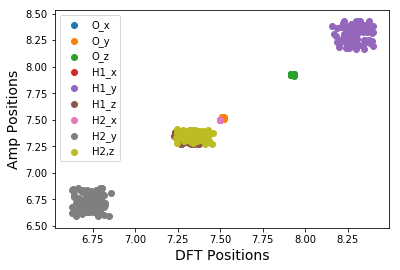

In [55]:
%matplotlib inline
import matplotlib.pyplot as plt
labels = np.array([['O_x', 'O_y', 'O_z'], ['H1_x', 'H1_y', 'H1_z'], ['H2_x', 'H2_y', 'H2,z']])
for i in range(3):
    for j in range(3):
      plt.scatter(dft_positions[:,i,j], amp_positions[:,i,j], label=labels[i,j])
plt.xlabel('DFT Positions', fontsize=14)
plt.ylabel('Amp Positions', fontsize=14)
plt.legend()
plt.show()

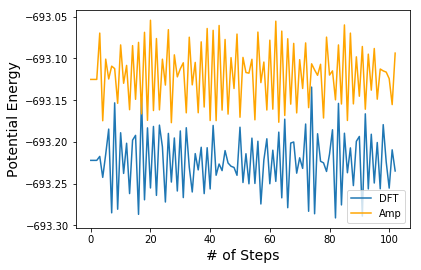

In [56]:
plt.figure()
plt.plot(np.arange(len(dft_potential)), dft_potential/3, label='DFT')
plt.plot(np.arange(len(amp_potential)), amp_potential/3, c='orange', label='Amp')
plt.xlabel('# of Steps', fontsize=14)
plt.ylabel('Potential Energy', fontsize=14)
plt.legend()
plt.show()